In [322]:
import pandas as pd
import numpy as np
import sqlite3
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from scipy import stats
from statsmodels.stats.weightstats import ttest_ind


In [31]:
con = sqlite3.connect(r'zippedData\im.db\im.db')

cur = con.cursor()

cur.execute("SELECT name from sqlite_master").fetchall()

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [32]:
#directors has person_id,movie_id
#writers has movie_id,person_id
#known_for has person_id,movie_id
#movie_ratings movie_id,averagerating,numvotes
#persons has person_id,primary_name,birth_year,death_year,primary_profession
#principals has movie_id,person_id,category,job,characters
#movie_akas has movie_id,ordering,title,region,language,types,attributes,is_original_title
#movie_basics has movie_id,primary_title,original_title,start_year,runtime_minutes,genres

#persons,principals,movie_akas,movie_basics,movie_ratings are the only tables we need for all the columns in the db

combined = """SELECT *
                from principals
                JOIN movie_akas USING (movie_id)
                JOIN movie_basics USING (movie_id)
                JOIN movie_ratings USING (movie_id)
                JOIN persons USING (person_id);"""

combined_df = pd.read_sql_query(combined,con)
combined_df.head()



,movie_id,ordering,person_id,category,job,characters,ordering,title,region,language,...,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,primary_name,birth_year,death_year,primary_profession
0,tt0323808,10,nm0059247,editor,None,None,1,May Day,GB,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
1,tt0323808,10,nm0059247,editor,None,None,2,Cowboys for Christ,GB,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
2,tt0323808,10,nm0059247,editor,None,None,3,The Wicker Tree,GB,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
3,tt0323808,10,nm0059247,editor,None,None,4,The Wicker Tree,None,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"
4,tt0323808,10,nm0059247,editor,None,None,5,Плетеное дерево,RU,None,...,The Wicker Tree,2011,96.0,"Drama,Horror",3.9,2328,Sean Barton,1944.0,NaN,"editor,editorial_department,assistant_director"


In [33]:
imdb_df = combined_df.copy()
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422866 entries, 0 to 2422865
Data columns (total 24 columns):
 #   Column              Dtype  
---  ------              -----  
 0   movie_id            object 
 1   ordering            int64  
 2   person_id           object 
 3   category            object 
 4   job                 object 
 5   characters          object 
 6   ordering            int64  
 7   title               object 
 8   region              object 
 9   language            object 
 10  types               object 
 11  attributes          object 
 12  is_original_title   float64
 13  primary_title       object 
 14  original_title      object 
 15  start_year          int64  
 16  runtime_minutes     float64
 17  genres              object 
 18  averagerating       float64
 19  numvotes            int64  
 20  primary_name        object 
 21  birth_year          float64
 22  death_year          float64
 23  primary_profession  object 
dtypes: float64(5), int64(4),

In [34]:
#The columns with missing values
imdb_df.isna().any()[imdb_df.isna().any() == True]

job                   True
characters            True
region                True
language              True
types                 True
attributes            True
runtime_minutes       True
genres                True
birth_year            True
death_year            True
primary_profession    True
dtype: bool

In [35]:
#percentage null values
imdb_df.isna().mean()[imdb_df.isna().mean() > 0].sort_values(ascending=False)

death_year            0.982493
attributes            0.949760
language              0.855840
job                   0.725228
characters            0.606105
birth_year            0.564602
types                 0.402041
region                0.162510
runtime_minutes       0.039211
primary_profession    0.021650
genres                0.003738
dtype: float64

In [36]:
#dropping the columns with 40%+ null values
imdb_df.drop(labels=['death_year','attributes','language','job','characters','birth_year','types'],axis=1,inplace=True)

#checking columns with null values.
imdb_df.isna().mean()[imdb_df.isna().mean() > 0].sort_values(ascending=False)

region                0.162510
runtime_minutes       0.039211
primary_profession    0.021650
genres                0.003738
dtype: float64

In [37]:
columns_with_null_values = imdb_df.isna().mean()[imdb_df.isna().mean() > 0].index.tolist()
columns_with_null_values

['region', 'runtime_minutes', 'genres', 'primary_profession']

In [38]:
#I will drop all the rows with null values since they are only a small percentage of the dataset.
imdb_df.dropna(axis=0,subset=columns_with_null_values,inplace=True)
#checking columns with null values.
imdb_df.isna().mean()[imdb_df.isna().mean() > 0].sort_values(ascending=False)

Series([], dtype: float64)

In [39]:
imdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1909588 entries, 0 to 2422865
Data columns (total 17 columns):
 #   Column              Dtype  
---  ------              -----  
 0   movie_id            object 
 1   ordering            int64  
 2   person_id           object 
 3   category            object 
 4   ordering            int64  
 5   title               object 
 6   region              object 
 7   is_original_title   float64
 8   primary_title       object 
 9   original_title      object 
 10  start_year          int64  
 11  runtime_minutes     float64
 12  genres              object 
 13  averagerating       float64
 14  numvotes            int64  
 15  primary_name        object 
 16  primary_profession  object 
dtypes: float64(3), int64(4), object(10)
memory usage: 262.2+ MB


In [40]:
#confirming if any rows have na values again
imdb_df.isna().any()[imdb_df.isna().any() == True]

Series([], dtype: bool)

In [41]:
imdb_duplicates = imdb_df[imdb_df.duplicated()] #.index.to_list()
imdb_duplicates.size
#the size of the dataframe with duplicated values is 0 meaning there are no duplicates in our dataset

0

In [42]:
# imdb_df.columns
imdb_df['genres'].head()

0    Drama,Horror
1    Drama,Horror
2    Drama,Horror
4    Drama,Horror
5    Drama,Horror
Name: genres, dtype: object

### **Rotten Tomatoes Data**

##### Steps to follow using the data

##### 1. Import the rotten tomatoes movie info dataframe and rotten tomatoes movie reviews dataframe.

##### 2. Check for null value percentage in the columns.

##### 3. Remove columns with more than 40% missing data.

##### 4. Remove null value rows in the remaining column.

##### 5. Check for and remove duplicated rows.

##### 6. Merge the two datasets.

##### 7. If possible try find a method of getting the movie names
##### This might involve downloading another dataset and getting movie names from there. Or finding a common column to the imdb or the numbers dataset (maybe release date or budget or income or review.)

In [43]:
rt_movie_info = pd.read_csv(r'zippedData/rt.movie_info.tsv/rt.movie_info.tsv',sep='\t')

rt_movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


In [44]:
# rt_movie_info['formatted_date'] = rt_movie_info['theater_date'].dt.strftime("%Y-%m-%d")
rt_movie_info['formatted_date'] = pd.to_datetime(rt_movie_info['theater_date'])
rt_movie_info.head()

,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio,formatted_date
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN,1971-10-09
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One,2012-08-17
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN,1996-09-13
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN,1994-12-09
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN,NaT


In [45]:
rt_movie_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              1560 non-null   int64         
 1   synopsis        1498 non-null   object        
 2   rating          1557 non-null   object        
 3   genre           1552 non-null   object        
 4   director        1361 non-null   object        
 5   writer          1111 non-null   object        
 6   theater_date    1201 non-null   object        
 7   dvd_date        1201 non-null   object        
 8   currency        340 non-null    object        
 9   box_office      340 non-null    object        
 10  runtime         1530 non-null   object        
 11  studio          494 non-null    object        
 12  formatted_date  1201 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(11)
memory usage: 158.6+ KB


In [46]:
rt_movie_info.isna().any()

id                False
synopsis           True
rating             True
genre              True
director           True
writer             True
theater_date       True
dvd_date           True
currency           True
box_office         True
runtime            True
studio             True
formatted_date     True
dtype: bool

In [47]:
rt_movie_info['rating'].value_counts()

R        521
NR       503
PG       240
PG-13    235
G         57
NC17       1
Name: rating, dtype: int64

In [48]:
rt_movie_info.groupby('genre').describe()

id               \
                                                   count         mean   
genre                                                                   
Action and Adventure                                19.0  1016.842105   
Action and Adventure|Animation|Art House and In...   1.0   135.000000   
Action and Adventure|Animation|Classics|Comedy|...   1.0  1156.000000   
Action and Adventure|Animation|Comedy                1.0   564.000000   
Action and Adventure|Animation|Comedy|Drama|Kid...   1.0  1418.000000   
...                                                  ...          ...   
Science Fiction and Fantasy                          6.0  1339.333333   
Science Fiction and Fantasy|Romance                  1.0  1908.000000   
Special Interest                                     1.0   636.000000   
Special Interest|Sports and Fitness                  1.0   265.000000   
Western                                              5.0  1260.000000   

                                                                        \
                                                           std     min   
genre                                                                    
Action and Adventure                                595.676484    70.0   
Action and Adventure|Animation|Art House and In...         NaN   135.0   
Action and Adventure|Animation|Classics|Comedy|...         NaN  1156.0   
Action and Adventure|Animation|Comedy                      NaN   564.0   
Action and Adventure|Animation|Comedy|Drama|Kid...         NaN  1418.0   
...                                                        ...     ...   
Science Fiction and Fantasy                         331.349765   835.0   
Science Fiction and Fantasy|Romance                        NaN  1908.0   
Special Interest                                           NaN   636.0   
Special Interest|Sports and Fitness                        NaN   265.0   
Western                                             429.774941   732.0   

                                                                             \
                                                        25%     50%     75%   
genre                                                                         
Action and Adventure                                 481.00   774.0  1593.5   
Action and Adventure|Animation|Art House and In...   135.00   135.0   135.0   
Action and Adventure|Animation|Classics|Comedy|...  1156.00  1156.0  1156.0   
Action and Adventure|Animation|Comedy                564.00   564.0   564.0   
Action and Adventure|Animation|Comedy|Drama|Kid...  1418.00  1418.0  1418.0   
...                                                     ...     ...     ...   
Science Fiction and Fantasy                         1138.25  1402.5  1615.0   
Science Fiction and Fantasy|Romance                 1908.00  1908.0  1908.0   
Special Interest                                     636.00   636.0   636.0   
Special Interest|Sports and Fitness                  265.00   265.0   265.0   
Western                                              880.00  1468.0  1493.0   

                                                            
                                                       max  
genre                                                       
Action and Adventure                                1913.0  
Action and Adventure|Animation|Art House and In...   135.0  
Action and Adventure|Animation|Classics|Comedy|...  1156.0  
Action and Adventure|Animation|Comedy                564.0  
Action and Adventure|Animation|Comedy|Drama|Kid...  1418.0  
...                                                    ...  
Science Fiction and Fantasy                         1660.0  
Science Fiction and Fantasy|Romance                 1908.0  
Special Interest                                     636.0  
Special Interest|Sports and Fitness                  265.0  
Western                                             1727.0  

[299 rows x 8 columns]

In [49]:
#these are critic reviews. They might not correlate with how much money the movie made
rt_reviews = pd.read_csv(r'zippedData\rt.reviews.tsv\rt.reviews.tsv',sep='\t',encoding='unicode_escape') #,on_bad_lines='skip'

rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


In [50]:
rt_reviews['formatted_date'] = pd.to_datetime(rt_reviews['date'])
rt_reviews.head()

,id,review,rating,fresh,critic,top_critic,publisher,date,formatted_date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",2018-11-10
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",2018-05-23
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",2018-01-04
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",2017-11-16
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",2017-10-12


In [51]:
# rt_movie_info[rt_movie_info['id'] == 3]
rt_movie_info['box_office'].dtypes

dtype('O')

In [52]:
rt_reviews[rt_reviews['id'] == 3]

,id,review,rating,fresh,critic,top_critic,publisher,date,formatted_date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",2018-11-10
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",2018-05-23
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",2018-01-04
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",2017-11-16
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",2017-10-12
...,...,...,...,...,...,...,...,...,...
158,3,Beyond its withering critique of contemporary ...,NaN,fresh,David Jenkins,0,Little White Lies,"May 25, 2012",2012-05-25
159,3,"Threatens to soar and to be important, but it ...",3/5,fresh,Dave Calhoun,1,Time Out,"May 25, 2012",2012-05-25
160,3,A parade of hollow didactic encounters.,NaN,rotten,Owen Gleiberman,1,Entertainment Weekly,"May 25, 2012",2012-05-25
161,3,[An] agonisingly self-conscious and meagre pie...,2/5,rotten,Peter Bradshaw,0,Guardian,"May 25, 2012",2012-05-25


In [53]:
rt_reviews.columns

Index(['id', 'review', 'rating', 'fresh', 'critic', 'top_critic', 'publisher',
       'date', 'formatted_date'],
      dtype='object')

#### Fresh Rating

In [54]:
rt_reviews['fresh'].value_counts()

fresh     33035
rotten    21397
Name: fresh, dtype: int64

In [55]:
# rt_reviews['rating'].value_counts()
rt_reviews['rating']

0          3/5
1          NaN
2          NaN
3          NaN
4          NaN
         ...  
54427      NaN
54428      1/5
54429      2/5
54430    2.5/5
54431      3/5
Name: rating, Length: 54432, dtype: object

In [56]:
rt_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   id              54432 non-null  int64         
 1   review          48869 non-null  object        
 2   rating          40915 non-null  object        
 3   fresh           54432 non-null  object        
 4   critic          51710 non-null  object        
 5   top_critic      54432 non-null  int64         
 6   publisher       54123 non-null  object        
 7   date            54432 non-null  object        
 8   formatted_date  54432 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 3.7+ MB


In [57]:
rt_reviews.isna().any()

id                False
review             True
rating             True
fresh             False
critic             True
top_critic        False
publisher          True
date              False
formatted_date    False
dtype: bool

In [58]:
rt_reviews['id'].value_counts()

782     338
1067    275
1525    262
1777    260
1083    260
       ... 
28        1
102       1
348       1
476       1
1727      1
Name: id, Length: 1135, dtype: int64

In [59]:
#lets forget about rotten tomatoes for now
#lets look at the tn.movie_gross dataset, the tmdb dataset and the bom.movie_gross
#all these datasets have a movie name column.
#maybe we can combine them using this column. if successful we will be able to find the ratings,budget and income of the movies


In [60]:
tmdb_movies_df = pd.read_csv(r'zippedData\tmdb.movies.csv\tmdb.movies.csv')
tmdb_movies_df.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [61]:
tmdb_movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26517 entries, 0 to 26516
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         26517 non-null  int64  
 1   genre_ids          26517 non-null  object 
 2   id                 26517 non-null  int64  
 3   original_language  26517 non-null  object 
 4   original_title     26517 non-null  object 
 5   popularity         26517 non-null  float64
 6   release_date       26517 non-null  object 
 7   title              26517 non-null  object 
 8   vote_average       26517 non-null  float64
 9   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(3), object(5)
memory usage: 2.0+ MB


In [62]:
movie_budgets_df = pd.read_csv(r'zippedData\tn.movie_budgets.csv\tn.movie_budgets.csv') #,on_bad_lines='skip'

movie_budgets_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [63]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [64]:
movie_gross_df = pd.read_csv(r'zippedData\bom.movie_gross.csv\bom.movie_gross.csv')
movie_gross_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [65]:
movie_budgets_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [66]:
#try merge movies_gross_df with tmdb_movies_df

merge_df_1 = pd.merge(tmdb_movies_df,movie_gross_df,left_on='title',right_on='title')

merge_df_1.head()

,Unnamed: 0,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count,studio,domestic_gross,foreign_gross,year
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000,2010
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,312400000.0,311500000,2010
2,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,WB,292600000.0,535700000,2010
3,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,BV,415000000.0,652000000,2010
4,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057,Uni.,251500000.0,291600000,2010


In [67]:
merge_df_1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2703 entries, 0 to 2702
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         2703 non-null   int64  
 1   genre_ids          2703 non-null   object 
 2   id                 2703 non-null   int64  
 3   original_language  2703 non-null   object 
 4   original_title     2703 non-null   object 
 5   popularity         2703 non-null   float64
 6   release_date       2703 non-null   object 
 7   title              2703 non-null   object 
 8   vote_average       2703 non-null   float64
 9   vote_count         2703 non-null   int64  
 10  studio             2702 non-null   object 
 11  domestic_gross     2682 non-null   float64
 12  foreign_gross      1723 non-null   object 
 13  year               2703 non-null   int64  
dtypes: float64(3), int64(4), object(7)
memory usage: 316.8+ KB


In [68]:
#merge the combination df with bom_movie_budgets

merge_df_2 = pd.merge(merge_df_1,movie_budgets_df,left_on='title',right_on='movie')

merge_df_2.head()

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,studio,domestic_gross_x,foreign_gross,year,id_y,release_date_y,movie,production_budget,domestic_gross_y,worldwide_gross
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000,2010,30,"Mar 26, 2010",How to Train Your Dragon,"$165,000,000","$217,581,232","$494,870,992"
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,312400000.0,311500000,2010,15,"May 7, 2010",Iron Man 2,"$170,000,000","$312,433,331","$621,156,389"
2,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,WB,292600000.0,535700000,2010,38,"Jul 16, 2010",Inception,"$160,000,000","$292,576,195","$835,524,642"
3,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,BV,415000000.0,652000000,2010,47,"Jun 18, 2010",Toy Story 3,"$200,000,000","$415,004,880","$1,068,879,522"
4,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057,Uni.,251500000.0,291600000,2010,50,"Jul 9, 2010",Despicable Me,"$69,000,000","$251,513,985","$543,464,573"


In [69]:
merge_df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1395 entries, 0 to 1394
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1395 non-null   int64  
 1   genre_ids          1395 non-null   object 
 2   id_x               1395 non-null   int64  
 3   original_language  1395 non-null   object 
 4   original_title     1395 non-null   object 
 5   popularity         1395 non-null   float64
 6   release_date_x     1395 non-null   object 
 7   title              1395 non-null   object 
 8   vote_average       1395 non-null   float64
 9   vote_count         1395 non-null   int64  
 10  studio             1394 non-null   object 
 11  domestic_gross_x   1393 non-null   float64
 12  foreign_gross      1200 non-null   object 
 13  year               1395 non-null   int64  
 14  id_y               1395 non-null   int64  
 15  release_date_y     1395 non-null   object 
 16  movie              1395 

In [70]:
#lets see how many rows we would have if we only merged gross and budget
merge_df_1b = pd.merge(movie_gross_df,movie_budgets_df,left_on='title',right_on='movie')

merge_df_1b.head()


,title,studio,domestic_gross_x,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_y,worldwide_gross
0,Toy Story 3,BV,415000000.0,652000000,2010,47,"Jun 18, 2010",Toy Story 3,"$200,000,000","$415,004,880","$1,068,879,522"
1,Inception,WB,292600000.0,535700000,2010,38,"Jul 16, 2010",Inception,"$160,000,000","$292,576,195","$835,524,642"
2,Shrek Forever After,P/DW,238700000.0,513900000,2010,27,"May 21, 2010",Shrek Forever After,"$165,000,000","$238,736,787","$756,244,673"
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010,53,"Jun 30, 2010",The Twilight Saga: Eclipse,"$68,000,000","$300,531,751","$706,102,828"
4,Iron Man 2,Par.,312400000.0,311500000,2010,15,"May 7, 2010",Iron Man 2,"$170,000,000","$312,433,331","$621,156,389"


In [71]:
#we have fewer records if we merge gross and budgets without tmdb
merge_df_1b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1247 entries, 0 to 1246
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              1247 non-null   object 
 1   studio             1246 non-null   object 
 2   domestic_gross_x   1245 non-null   float64
 3   foreign_gross      1086 non-null   object 
 4   year               1247 non-null   int64  
 5   id                 1247 non-null   int64  
 6   release_date       1247 non-null   object 
 7   movie              1247 non-null   object 
 8   production_budget  1247 non-null   object 
 9   domestic_gross_y   1247 non-null   object 
 10  worldwide_gross    1247 non-null   object 
dtypes: float64(1), int64(2), object(8)
memory usage: 116.9+ KB


In [72]:
merge_df_2.columns

Index(['Unnamed: 0', 'genre_ids', 'id_x', 'original_language',
       'original_title', 'popularity', 'release_date_x', 'title',
       'vote_average', 'vote_count', 'studio', 'domestic_gross_x',
       'foreign_gross', 'year', 'id_y', 'release_date_y', 'movie',
       'production_budget', 'domestic_gross_y', 'worldwide_gross'],
      dtype='object')

In [73]:
merge_df_2.head()

,Unnamed: 0,genre_ids,id_x,original_language,original_title,popularity,release_date_x,title,vote_average,vote_count,studio,domestic_gross_x,foreign_gross,year,id_y,release_date_y,movie,production_budget,domestic_gross_y,worldwide_gross
0,1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610,P/DW,217600000.0,277300000,2010,30,"Mar 26, 2010",How to Train Your Dragon,"$165,000,000","$217,581,232","$494,870,992"
1,2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368,Par.,312400000.0,311500000,2010,15,"May 7, 2010",Iron Man 2,"$170,000,000","$312,433,331","$621,156,389"
2,4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186,WB,292600000.0,535700000,2010,38,"Jul 16, 2010",Inception,"$160,000,000","$292,576,195","$835,524,642"
3,7,"[16, 10751, 35]",10193,en,Toy Story 3,24.445,2010-06-17,Toy Story 3,7.7,8340,BV,415000000.0,652000000,2010,47,"Jun 18, 2010",Toy Story 3,"$200,000,000","$415,004,880","$1,068,879,522"
4,8,"[16, 10751, 35]",20352,en,Despicable Me,23.673,2010-07-09,Despicable Me,7.2,10057,Uni.,251500000.0,291600000,2010,50,"Jul 9, 2010",Despicable Me,"$69,000,000","$251,513,985","$543,464,573"


In [74]:
merge_df_2['genre_ids'].value_counts()

[18]                       119
[35]                        80
[35, 18]                    43
[18, 10749]                 35
[27, 53]                    31
                          ... 
[18, 27, 14]                 1
[12, 35, 14, 10751, 27]      1
[28, 35, 12]                 1
[53, 28, 80, 9648]           1
[28, 35, 53, 10749]          1
Name: genre_ids, Length: 467, dtype: int64

I will investigate the properties of merge_df_2

plot popularity vs gross

I want to plot budget vs domestic gross

budget vs foreign gross

budget vs total gross

Plot rating vs domestic gross

Plot rating vs foreign gross

plot rating vs total gross

language vs gross

year vs gross

studio vs gross






<AxesSubplot:xlabel='popularity'>

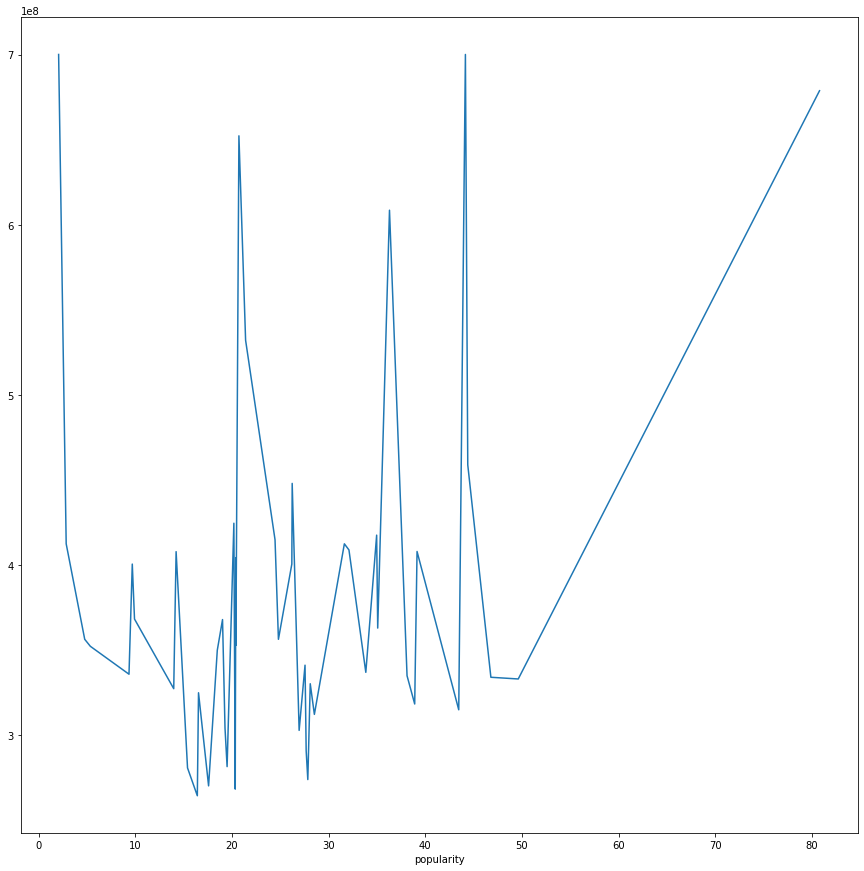

In [75]:
#plotting popularity vs gross
fig,ax = plt.subplots(figsize=(15,15))
pop_domGross = merge_df_2.groupby('popularity').mean().sort_values('domestic_gross_x',ascending=False)
pop_domGross_top_50 = pop_domGross['domestic_gross_x'].head(50)
# pop_domGross_top_100

sns.lineplot(x=pop_domGross_top_50.index,y=pop_domGross_top_50.values)


<AxesSubplot:xlabel='studio', ylabel='domestic_gross_x'>

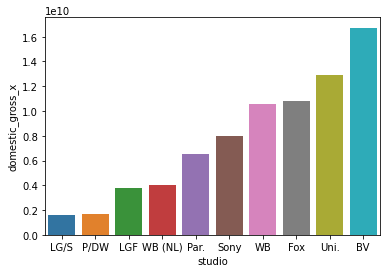

In [76]:
studio_gross = merge_df_2.groupby('studio').sum().sort_values('domestic_gross_x',ascending=True)
studio_gross_filtered = studio_gross[studio_gross['domestic_gross_x'] > 150*10**7]
# studio_gross_filtered.info()

sns.barplot(data=studio_gross_filtered,x=studio_gross_filtered.index,y=studio_gross_filtered['domestic_gross_x'] )

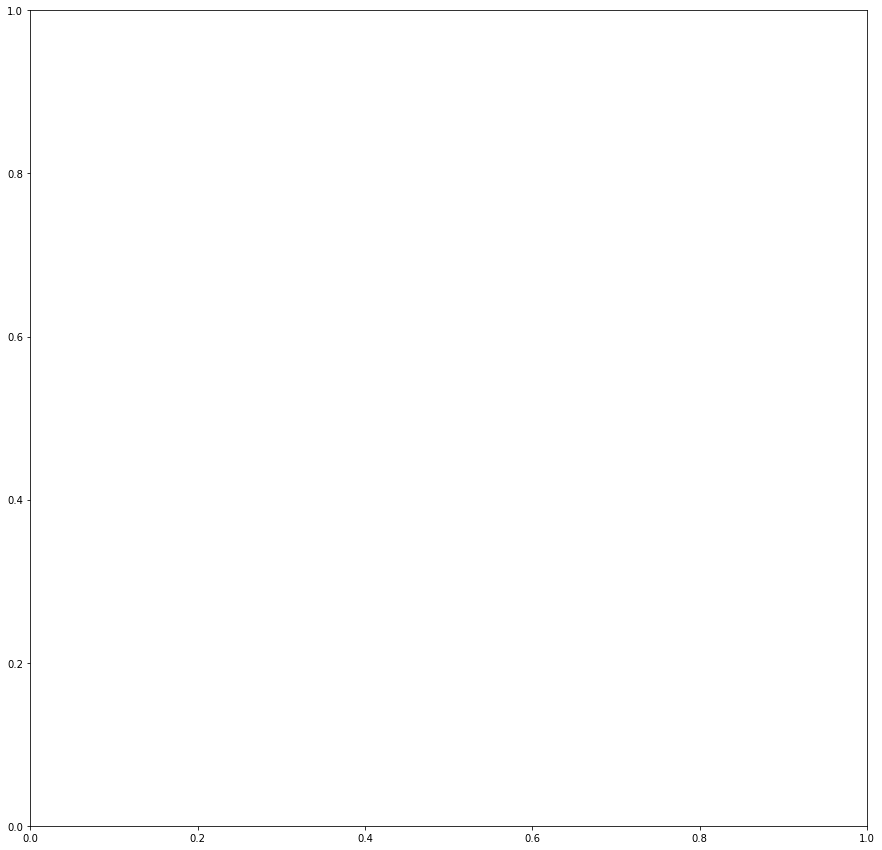

In [77]:
#plotting budget vs gross
fig,ax = plt.subplots(figsize=(15,15))
budget_vs_gross = merge_df_2.groupby('production_budget').sum().sort_values('domestic_gross_x',ascending=False)
budget_vs_gross_top_50 = budget_vs_gross['domestic_gross_x'].head(50)
x_ticks = np.linspace(budget_vs_gross_top_50.values.min(),budget_vs_gross_top_50.values.max(),25)
# x_ticks
# sns.lineplot(data=budget_vs_gross_top_50,x=budget_vs_gross_top_50.index,y=budget_vs_gross_top_50.values)
# plt.xticks(rotation=90,ticks=x_ticks)
# plt.show()

In [78]:
imdb_gross_combine = pd.merge(imdb_df,movie_gross_df,on='title')
imdb_gross_combine

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title,...,runtime_minutes,genres,averagerating,numvotes,primary_name,primary_profession,studio,domestic_gross,foreign_gross,year
0,tt0475290,10,nm0005683,cinematographer,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,106.0,"Comedy,Drama,Music",6.3,111422,Roger Deakins,"cinematographer,camera_department,miscellaneous",Uni.,30500000.0,33100000,2016
1,tt0475290,1,nm0000982,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,106.0,"Comedy,Drama,Music",6.3,111422,Josh Brolin,"actor,producer,writer",Uni.,30500000.0,33100000,2016
2,tt0475290,2,nm0000123,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,106.0,"Comedy,Drama,Music",6.3,111422,George Clooney,"actor,producer,director",Uni.,30500000.0,33100000,2016
3,tt0475290,3,nm2403277,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,106.0,"Comedy,Drama,Music",6.3,111422,Alden Ehrenreich,"actor,soundtrack",Uni.,30500000.0,33100000,2016
4,tt0475290,4,nm0000146,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,106.0,"Comedy,Drama,Music",6.3,111422,Ralph Fiennes,"actor,director,soundtrack",Uni.,30500000.0,33100000,2016
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80965,tt8119752,5,nm2891286,director,9,Gonjiam: Haunted Asylum,XWW,0.0,Gonjiam: Haunted Asylum,Gon-ji-am,...,95.0,"Horror,Mystery",6.1,2585,Beom-sik Jeong,"director,writer",WGUSA,115000.0,NaN,2018
80966,tt8119752,6,nm9687793,writer,9,Gonjiam: Haunted Asylum,XWW,0.0,Gonjiam: Haunted Asylum,Gon-ji-am,...,95.0,"Horror,Mystery",6.1,2585,Sang-min Park,writer,WGUSA,115000.0,NaN,2018
80967,tt8119752,7,nm3774009,producer,9,Gonjiam: Haunted Asylum,XWW,0.0,Gonjiam: Haunted Asylum,Gon-ji-am,...,95.0,"Horror,Mystery",6.1,2585,Won-guk Kim,producer,WGUSA,115000.0,NaN,2018
80968,tt8119752,8,nm10106374,cinematographer,9,Gonjiam: Haunted Asylum,XWW,0.0,Gonjiam: Haunted Asylum,Gon-ji-am,...,95.0,"Horror,Mystery",6.1,2585,Yoon Byung-Ho,"cinematographer,camera_department",WGUSA,115000.0,NaN,2018


In [79]:
imdb_gross_combine.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80970 entries, 0 to 80969
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            80970 non-null  object 
 1   ordering            80970 non-null  int64  
 2   person_id           80970 non-null  object 
 3   category            80970 non-null  object 
 4   ordering            80970 non-null  int64  
 5   title               80970 non-null  object 
 6   region              80970 non-null  object 
 7   is_original_title   80970 non-null  float64
 8   primary_title       80970 non-null  object 
 9   original_title      80970 non-null  object 
 10  start_year          80970 non-null  int64  
 11  runtime_minutes     80970 non-null  float64
 12  genres              80970 non-null  object 
 13  averagerating       80970 non-null  float64
 14  numvotes            80970 non-null  int64  
 15  primary_name        80970 non-null  object 
 16  prim

In [80]:
final_combined = pd.merge(imdb_gross_combine,movie_budgets_df,left_on='title',right_on='movie')
final_combined.head()

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title,...,studio,domestic_gross_x,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_y,worldwide_gross
0,tt0475290,10,nm0005683,cinematographer,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
1,tt0475290,1,nm0000982,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
2,tt0475290,2,nm0000123,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
3,tt0475290,3,nm2403277,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
4,tt0475290,4,nm0000146,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"


In [81]:
final_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45869 entries, 0 to 45868
Data columns (total 27 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            45869 non-null  object 
 1   ordering            45869 non-null  int64  
 2   person_id           45869 non-null  object 
 3   category            45869 non-null  object 
 4   ordering            45869 non-null  int64  
 5   title               45869 non-null  object 
 6   region              45869 non-null  object 
 7   is_original_title   45869 non-null  float64
 8   primary_title       45869 non-null  object 
 9   original_title      45869 non-null  object 
 10  start_year          45869 non-null  int64  
 11  runtime_minutes     45869 non-null  float64
 12  genres              45869 non-null  object 
 13  averagerating       45869 non-null  float64
 14  numvotes            45869 non-null  int64  
 15  primary_name        45869 non-null  object 
 16  prim

In [82]:
final_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'studio', 'domestic_gross_x',
       'foreign_gross', 'year', 'id', 'release_date', 'movie',
       'production_budget', 'domestic_gross_y', 'worldwide_gross'],
      dtype='object')

In [83]:
final_combined.head()
# final_combined[final_combined['primary_profession'] == "director"]['primary_profession'] #.groupby('primary_name').count()

# final_combined[final_combined['primary_name'] == 'Florian Eckhardt']['primary_profession']

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title,...,studio,domestic_gross_x,foreign_gross,year,id,release_date,movie,production_budget,domestic_gross_y,worldwide_gross
0,tt0475290,10,nm0005683,cinematographer,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
1,tt0475290,1,nm0000982,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
2,tt0475290,2,nm0000123,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
3,tt0475290,3,nm2403277,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"
4,tt0475290,4,nm0000146,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,Uni.,30500000.0,33100000,2016,22,"Feb 5, 2016","Hail, Caesar!","$22,000,000","$30,080,225","$64,160,680"


In [84]:
all_combined  = pd.merge(final_combined,tmdb_movies_df,on='title')
all_combined.head()

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title_x,...,worldwide_gross,Unnamed: 0,genre_ids,id_y,original_language,original_title_y,popularity,release_date_y,vote_average,vote_count
0,tt0475290,10,nm0005683,cinematographer,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,"$64,160,680",17497,"[35, 18, 9648]",270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328
1,tt0475290,1,nm0000982,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,"$64,160,680",17497,"[35, 18, 9648]",270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328
2,tt0475290,2,nm0000123,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,"$64,160,680",17497,"[35, 18, 9648]",270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328
3,tt0475290,3,nm2403277,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,"$64,160,680",17497,"[35, 18, 9648]",270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328
4,tt0475290,4,nm0000146,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,"$64,160,680",17497,"[35, 18, 9648]",270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328


In [85]:
all_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58129 entries, 0 to 58128
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            58129 non-null  object 
 1   ordering            58129 non-null  int64  
 2   person_id           58129 non-null  object 
 3   category            58129 non-null  object 
 4   ordering            58129 non-null  int64  
 5   title               58129 non-null  object 
 6   region              58129 non-null  object 
 7   is_original_title   58129 non-null  float64
 8   primary_title       58129 non-null  object 
 9   original_title_x    58129 non-null  object 
 10  start_year          58129 non-null  int64  
 11  runtime_minutes     58129 non-null  float64
 12  genres              58129 non-null  object 
 13  averagerating       58129 non-null  float64
 14  numvotes            58129 non-null  int64  
 15  primary_name        58129 non-null  object 
 16  prim

In [86]:
#zero rows
all_combined[all_combined.duplicated() == True]

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title_x,...,worldwide_gross,Unnamed: 0,genre_ids,id_y,original_language,original_title_y,popularity,release_date_y,vote_average,vote_count


In [87]:
missing_index = list(all_combined[all_combined.isna() == True ].index)

In [88]:
all_combined.isna().sum()[all_combined.isna().sum() > 0]

domestic_gross_x      10
foreign_gross       7152
dtype: int64

In [89]:
#since rows are few I will drop
all_combined.isna().mean()[all_combined.isna().mean() > 0]

domestic_gross_x    0.000172
foreign_gross       0.123037
dtype: float64

In [90]:
all_combined.dropna(axis=0,subset=['domestic_gross_x','foreign_gross'],inplace=True)
all_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50967 entries, 0 to 58128
Data columns (total 36 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   movie_id            50967 non-null  object 
 1   ordering            50967 non-null  int64  
 2   person_id           50967 non-null  object 
 3   category            50967 non-null  object 
 4   ordering            50967 non-null  int64  
 5   title               50967 non-null  object 
 6   region              50967 non-null  object 
 7   is_original_title   50967 non-null  float64
 8   primary_title       50967 non-null  object 
 9   original_title_x    50967 non-null  object 
 10  start_year          50967 non-null  int64  
 11  runtime_minutes     50967 non-null  float64
 12  genres              50967 non-null  object 
 13  averagerating       50967 non-null  float64
 14  numvotes            50967 non-null  int64  
 15  primary_name        50967 non-null  object 
 16  prim

In [91]:
#confirmation no na values
all_combined.isna().mean()[all_combined.isna().mean() > 0]
#no na values shown by empty result

Series([], dtype: float64)

In [92]:
all_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'studio', 'domestic_gross_x',
       'foreign_gross', 'year', 'id_x', 'release_date_x', 'movie',
       'production_budget', 'domestic_gross_y', 'worldwide_gross',
       'Unnamed: 0', 'genre_ids', 'id_y', 'original_language',
       'original_title_y', 'popularity', 'release_date_y', 'vote_average',
       'vote_count'],
      dtype='object')

In [93]:
#where it was produced
all_combined['region'].value_counts()

US    11558
FR     3217
CA     2915
ES     2800
DE     2383
      ...  
BA       10
EG       10
ET       10
CM       10
PR        8
Name: region, Length: 72, dtype: int64

In [95]:
rt_combined = pd.merge(rt_movie_info,rt_reviews, on='id')
rt_combined.head()

,id,synopsis,rating_x,genre,director,writer,theater_date,dvd_date,currency,box_office,...,studio,formatted_date_x,review,rating_y,fresh,critic,top_critic,publisher,date,formatted_date_y
0,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",...,Entertainment One,2012-08-17,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018",2018-11-10
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",...,Entertainment One,2012-08-17,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018",2018-05-23
2,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",...,Entertainment One,2012-08-17,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018",2018-01-04
3,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",...,Entertainment One,2012-08-17,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017",2017-11-16
4,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",...,Entertainment One,2012-08-17,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017",2017-10-12


In [96]:
rt_combined.columns

Index(['id', 'synopsis', 'rating_x', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio', 'formatted_date_x', 'review', 'rating_y', 'fresh', 'critic',
       'top_critic', 'publisher', 'date', 'formatted_date_y'],
      dtype='object')

In [97]:
rt_combined.isna().any()

id                  False
synopsis             True
rating_x             True
genre                True
director             True
writer               True
theater_date         True
dvd_date             True
currency             True
box_office           True
runtime              True
studio               True
formatted_date_x     True
review               True
rating_y             True
fresh               False
critic               True
top_critic          False
publisher            True
date                False
formatted_date_y    False
dtype: bool

In [98]:
rt_combined.columns

Index(['id', 'synopsis', 'rating_x', 'genre', 'director', 'writer',
       'theater_date', 'dvd_date', 'currency', 'box_office', 'runtime',
       'studio', 'formatted_date_x', 'review', 'rating_y', 'fresh', 'critic',
       'top_critic', 'publisher', 'date', 'formatted_date_y'],
      dtype='object')

In [99]:
all_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'studio', 'domestic_gross_x',
       'foreign_gross', 'year', 'id_x', 'release_date_x', 'movie',
       'production_budget', 'domestic_gross_y', 'worldwide_gross',
       'Unnamed: 0', 'genre_ids', 'id_y', 'original_language',
       'original_title_y', 'popularity', 'release_date_y', 'vote_average',
       'vote_count'],
      dtype='object')

In [ ]:
#from the unique values we need to remove the $ sign to make this column a float
# we need to do the same to the domestic_gross_x and the production_budget 
movie_budgets_df['worldwide_gross'].unique()

array(['$2,776,345,279', '$1,045,663,875', '$149,762,350', ...,
       '$240,495', '$1,338', '$181,041'], dtype=object)

In [105]:
all_combined['worldwide_gross'] = all_combined['worldwide_gross'].replace('[\$,]', '', regex=True).astype(float)
all_combined['domestic_gross_x'] = all_combined['domestic_gross_x'].replace('[\$,]', '', regex=True).astype(float)
all_combined['production_budget'] = all_combined['production_budget'].replace('[\$,]', '', regex=True).astype(float)


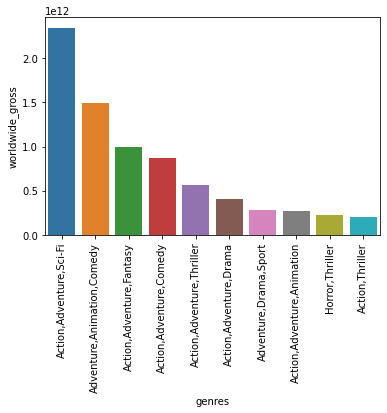

In [106]:
genre_groupby_pop = all_combined.groupby('genres').sum().sort_values('worldwide_gross',ascending=False).head(10)
genre_groupby_pop_top20 = genre_groupby_pop['worldwide_gross'].head(10)
xticks = genre_groupby_pop_top20.index
genre_groupby_pop_top20

genre_groupby_pop
# fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=genre_groupby_pop,x=genre_groupby_pop.index,y='worldwide_gross')
plt.xticks(rotation=90);


In [107]:
all_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'studio', 'domestic_gross_x',
       'foreign_gross', 'year', 'id_x', 'release_date_x', 'movie',
       'production_budget', 'domestic_gross_y', 'worldwide_gross',
       'Unnamed: 0', 'genre_ids', 'id_y', 'original_language',
       'original_title_y', 'popularity', 'release_date_y', 'vote_average',
       'vote_count'],
      dtype='object')

In [ ]:
#creating a profit column worldwide_gross - production_budget
all_combined['profits'] = all_combined['worldwide_gross'] - all_combined['production_budget']
all_combined[['profits','worldwide_gross','production_budget']].head()

,profits,worldwide_gross,production_budget
0,42160680.0,64160680.0,22000000.0
1,42160680.0,64160680.0,22000000.0
2,42160680.0,64160680.0,22000000.0
3,42160680.0,64160680.0,22000000.0
4,42160680.0,64160680.0,22000000.0


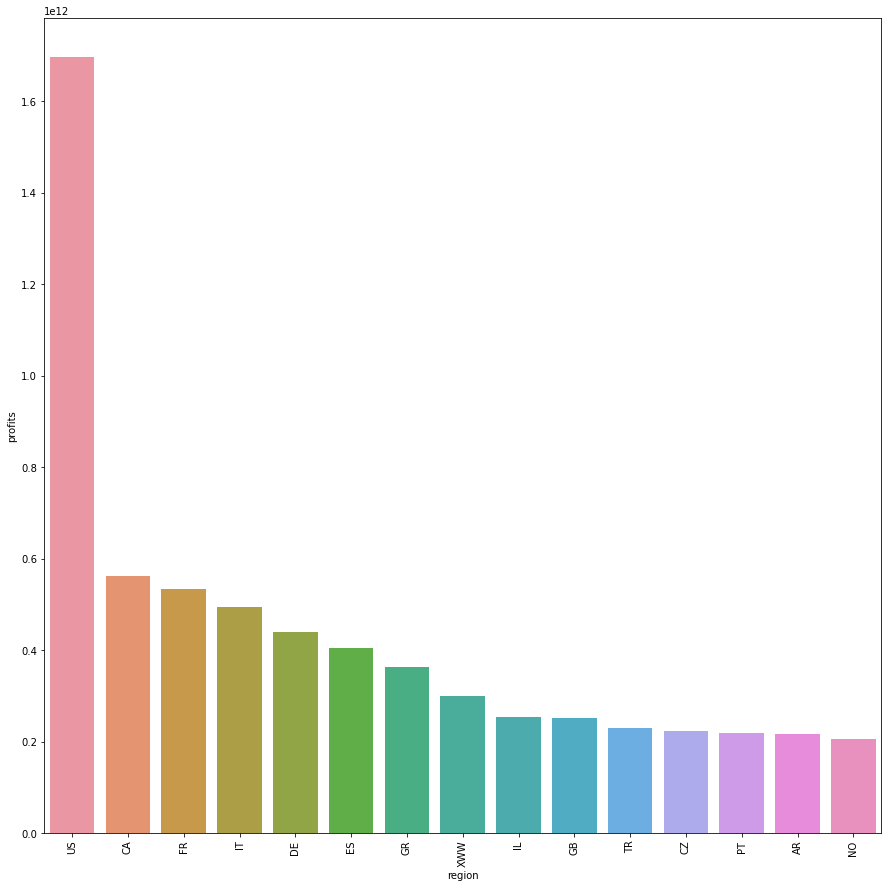

In [213]:
#group by region and find profits per region
region_groupby = all_combined.groupby('region').sum().sort_values('profits',ascending=False)
top_15_profits_regions = region_groupby.head(15)

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=top_15_profits_regions,x=top_15_profits_regions.index,y='profits')
plt.xticks(rotation=90);

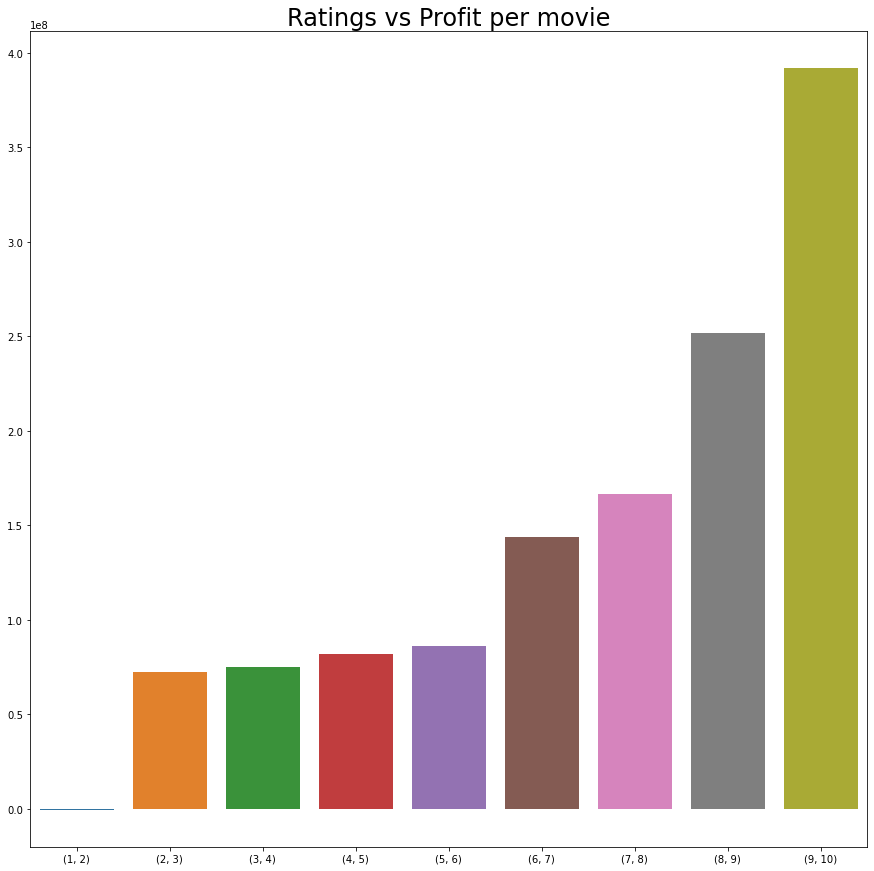

In [212]:
#group by averagerating vs profits per movie
#im gonna create bins for the ratings 1,2,3,4 to 10 
#then im gonna group by these bins plot binned ratings vs profits

rating_bins = [1,2,3,4,5,6,7,8,9,10]

all_combined['rating_bins'] = pd.cut(all_combined['averagerating'],bins=[0,1,2,3,4,5,6,7,8,9,10])


ratings_profits_sum = all_combined.groupby('rating_bins').sum().sort_values('profits',ascending=False)
ratings_movies_count = all_combined.groupby('rating_bins').count().sort_values('profits',ascending=False)
ratings_movie_numbers = ratings_movies_count['movie_id']

ratings_profits_per_movie = (ratings_profits_sum['profits']/ ratings_movie_numbers).dropna() #no movies rated 0-1 in df so there would be NA
ratings_profits_per_movie


rating_ranges=  [(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)]

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=ratings_profits_per_movie,x=ratings_profits_per_movie.index,y=ratings_profits_per_movie.values,)
ax.set_xticklabels(rating_ranges)
ax.set_title('Ratings vs Profit per movie',fontdict={'fontsize':24});



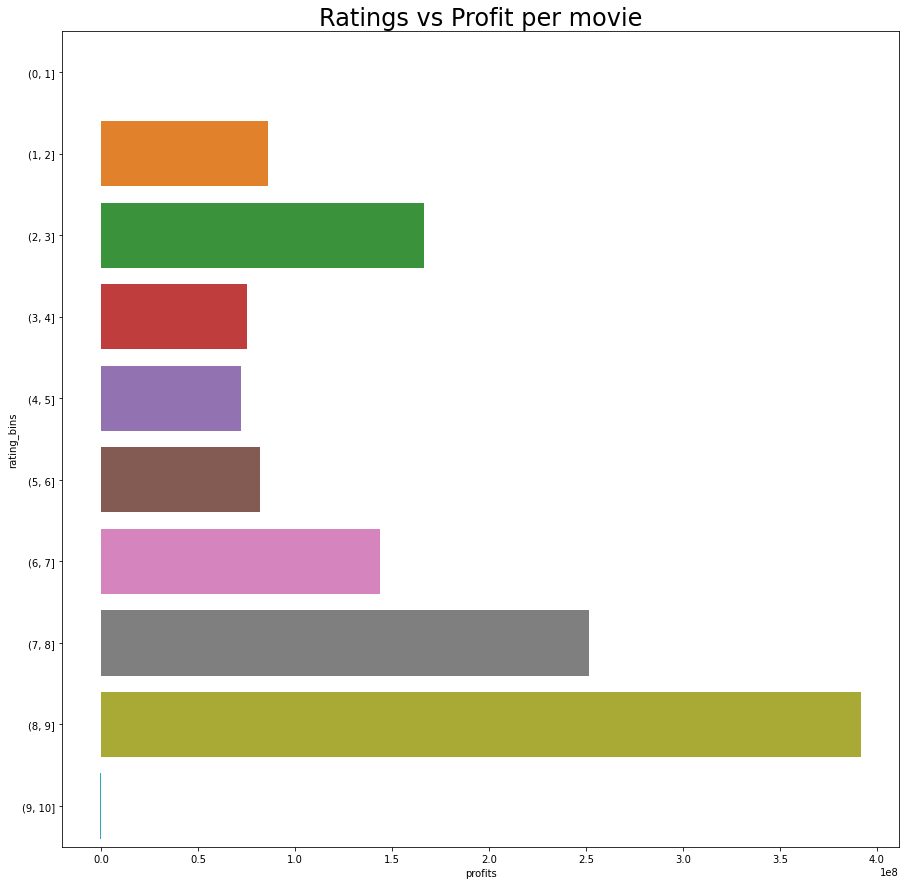

In [240]:
#group by averagerating vs profits per movie
#im gonna create bins for the ratings 1,2,3,4 to 10 
#then im gonna group by these bins plot binned ratings vs profits

rating_bins = [1,2,3,4,5,6,7,8,9,10]

all_combined['rating_bins'] = pd.cut(all_combined['averagerating'],bins=[0,1,2,3,4,5,6,7,8,9,10])


ratings_mean_profits = (all_combined.groupby('rating_bins').mean().sort_values('profits',ascending=False)).dropna()
ratings_mean_profits
# ratings_movies_count = all_combined.groupby('rating_bins').count().sort_values('profits',ascending=False)
# ratings_movie_numbers = ratings_movies_count['movie_id']

# ratings_profits_per_movie = (ratings_profits_sum['profits']/ ratings_movie_numbers).dropna() #no movies rated 0-1 in df so there would be NA
# ratings_profits_per_movie


# rating_ranges=  [(1,2),(2,3),(3,4),(4,5),(5,6),(6,7),(7,8),(8,9),(9,10)]

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data=ratings_mean_profits,y=ratings_mean_profits.index,x='profits')
# # ax.set_xticklabels(rating_ranges)
ax.set_title('Ratings vs Profit per movie',fontdict={'fontsize':24});

In [116]:
all_combined.to_csv('all_combined.csv',index=False)

In [145]:
all_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'studio', 'domestic_gross_x',
       'foreign_gross', 'year', 'id_x', 'release_date_x', 'movie',
       'production_budget', 'domestic_gross_y', 'worldwide_gross',
       'Unnamed: 0', 'genre_ids', 'id_y', 'original_language',
       'original_title_y', 'popularity', 'release_date_y', 'vote_average',
       'vote_count', 'profits', 'rating_bins'],
      dtype='object')

In [220]:
"""create new column called is director
search for director string in the primary_profession column
filter for directors == True
group by these primary_name
divide by the count of movies for each director
rank by profits
plot top 15 directors vs profits per movie"""

all_combined[all_combined['primary_profession'].str.contains('director') == True]['primary_profession']

2                  actor,producer,director
4                actor,director,soundtrack
5                 producer,writer,director
6                 producer,writer,director
10       assistant_director,producer,actor
                       ...                
58115    producer,director,cinematographer
58116    producer,director,cinematographer
58120      writer,director,cinematographer
58121      writer,director,cinematographer
58122      writer,director,cinematographer
Name: primary_profession, Length: 13054, dtype: object

Text(0.5, 1.0, 'Top 20 Directors ranked by average profit')

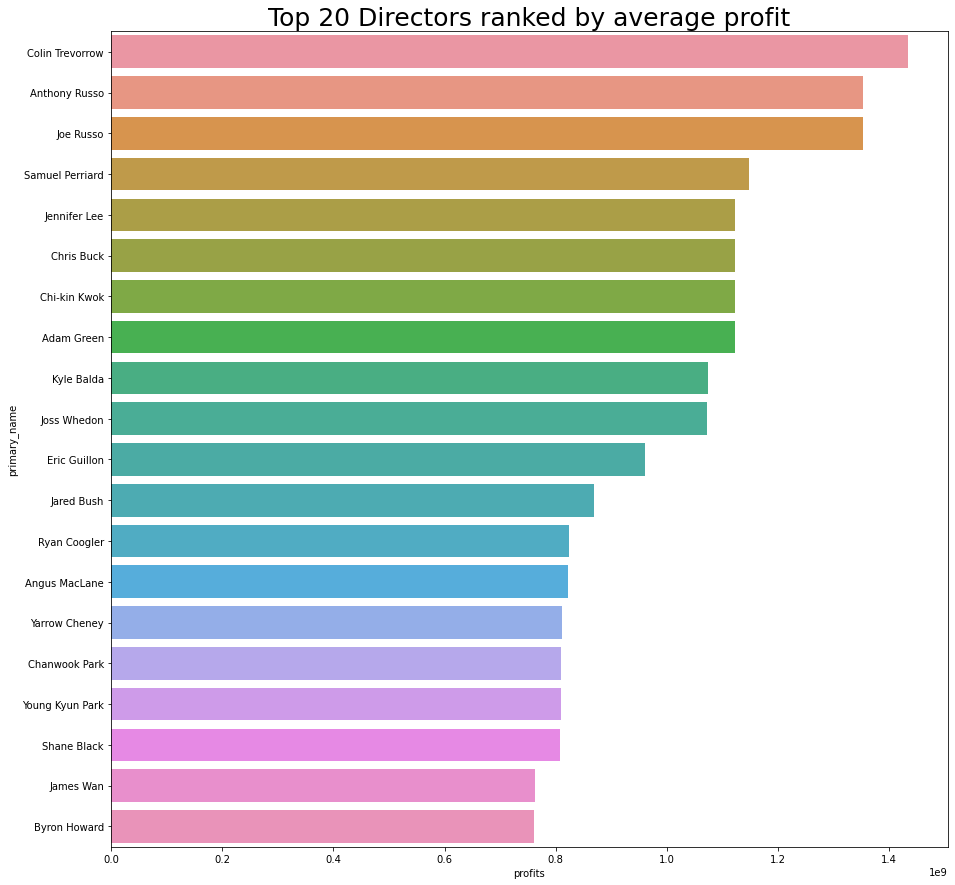

In [235]:
#average profits per director
directors_id_groupby = all_combined[all_combined['category'] == 'director'].groupby('primary_name').mean().sort_values('profits',ascending=False)
top_20_directors_by_profit = directors_id_groupby.head(20)
top_20_directors_by_profit

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data = top_20_directors_by_profit,x='profits',y=top_20_directors_by_profit.index)
ax.set_title('Top 20 Directors ranked by average profit',fontdict={'fontsize':25})


Text(0.5, 1.0, 'Top 30 Actors ranked by average profit')

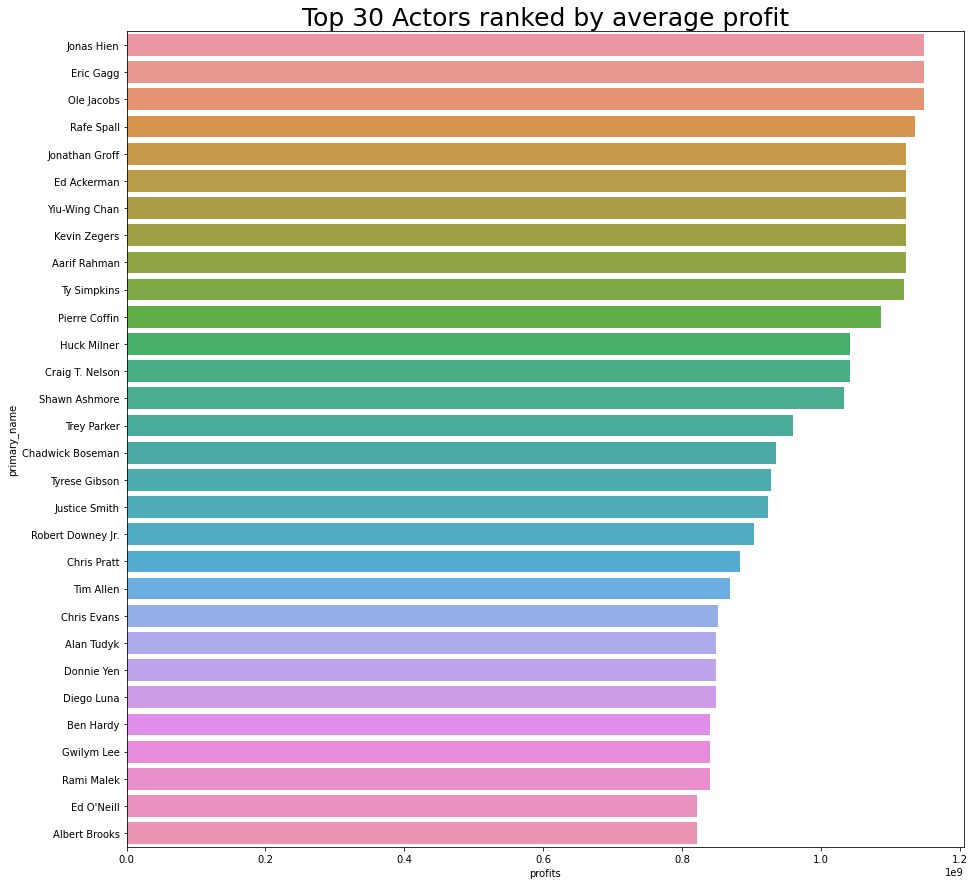

In [242]:
#average profits per director
directors_id_groupby = all_combined[all_combined['category'] == 'actor'].groupby('primary_name').mean().sort_values('profits',ascending=False)
top_20_directors_by_profit = directors_id_groupby.head(30)
top_20_directors_by_profit

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data = top_20_directors_by_profit,x='profits',y=top_20_directors_by_profit.index)
ax.set_title('Top 30 Actors ranked by average profit',fontdict={'fontsize':25})

Text(0.5, 1.0, 'Top 10 Genres ranked by average profit')

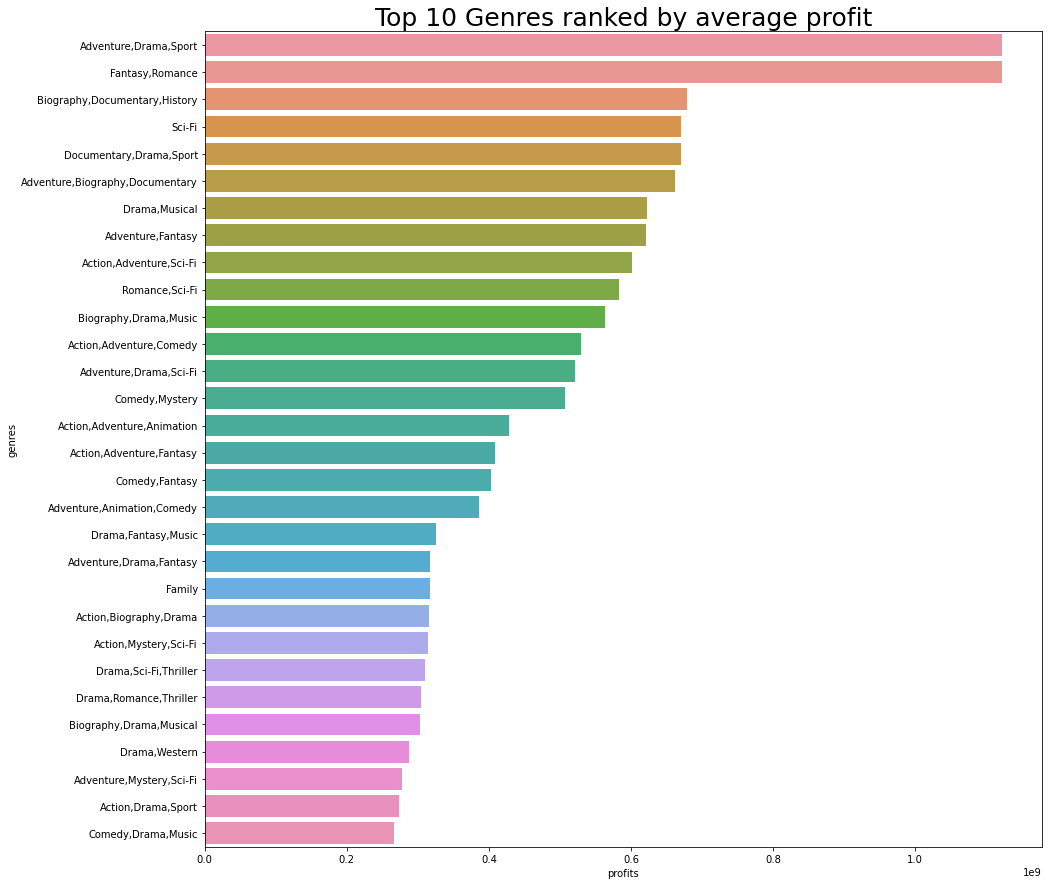

In [251]:
mean_genre_groupby = all_combined.groupby('genres').mean().sort_values('profits',ascending=False)
top_30_genres_average_profits = mean_genre_groupby.head(30)

fig,ax = plt.subplots(figsize=(15,15))
sns.barplot(data = top_30_genres_average_profits,x='profits',y=top_30_genres_average_profits.index)
ax.set_title('Top 10 Genres ranked by average profit',fontdict={'fontsize':25})


<AxesSubplot:xlabel='production_budget', ylabel='profits'>

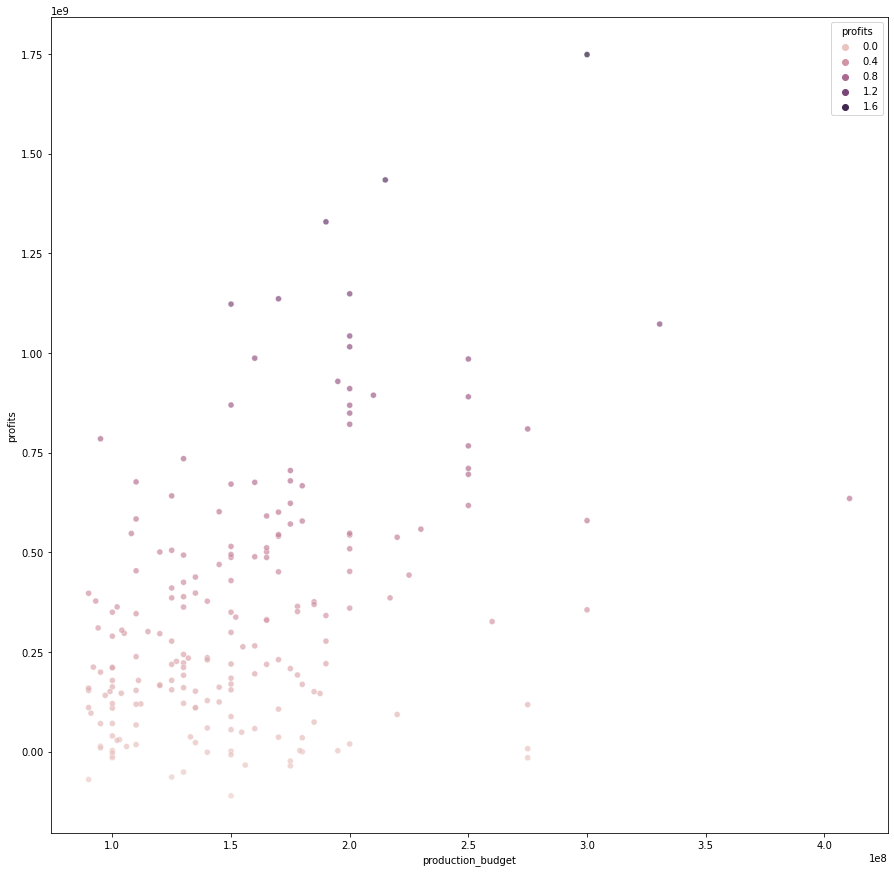

In [303]:
fig,ax = plt.subplots(figsize=(15,15))
movie_budgets_ranking  = all_combined.groupby('title').mean().sort_values('production_budget',ascending=False)
top_200_movie_budgets_ranking = movie_budgets_ranking.head(200)

sns.scatterplot(data=top_200_movie_budgets_ranking,x='production_budget',y='profits',alpha=0.7,hue='profits')


<AxesSubplot:xlabel='popularity', ylabel='worldwide_gross'>

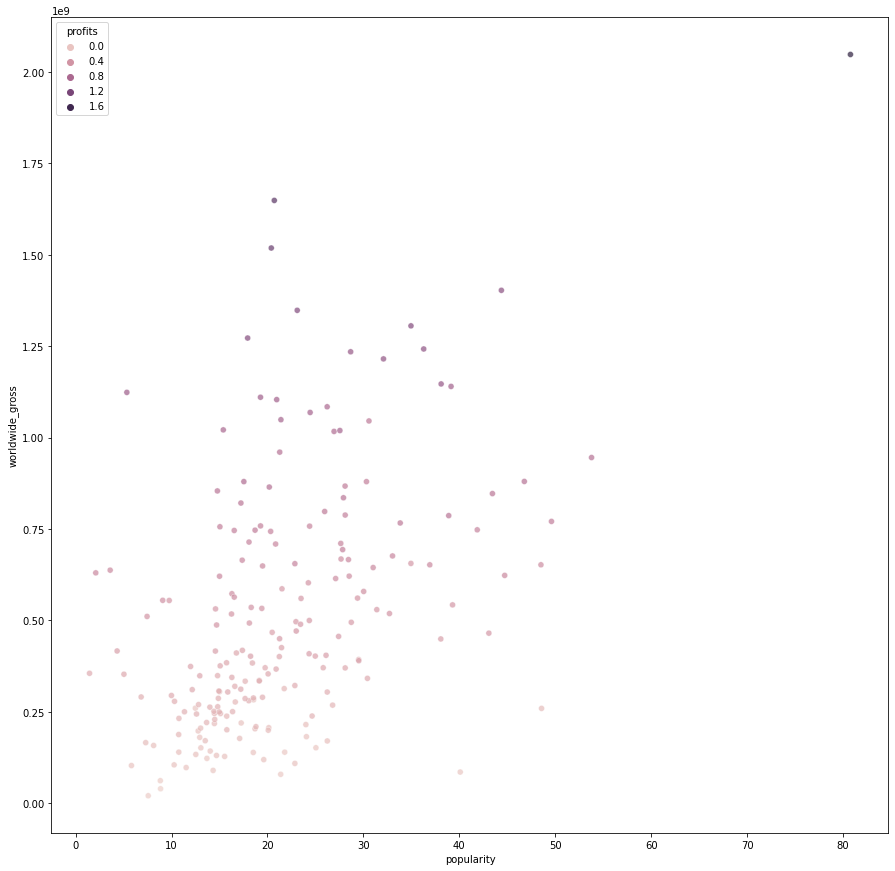

In [304]:
fig,ax = plt.subplots(figsize=(15,15))
actors_popularity_mean_gross  = all_combined[all_combined['category'] == 'actor'].groupby('primary_name').mean().sort_values('popularity',ascending=False)
top_200_popular_actors = movie_budgets_ranking.head(200)

sns.scatterplot(data=top_200_popular_actors,x='popularity',y='worldwide_gross',alpha=0.7,hue='profits')

In [284]:
all_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'studio', 'domestic_gross_x',
       'foreign_gross', 'year', 'id_x', 'release_date_x', 'movie',
       'production_budget', 'domestic_gross_y', 'worldwide_gross',
       'Unnamed: 0', 'genre_ids', 'id_y', 'original_language',
       'original_title_y', 'popularity', 'release_date_y', 'vote_average',
       'vote_count', 'profits', 'rating_bins'],
      dtype='object')

In [286]:
all_combined[['genres','vote_average','numvotes']].head()

,genres,vote_average,numvotes
0,"Comedy,Drama,Music",5.9,111422
1,"Comedy,Drama,Music",5.9,111422
2,"Comedy,Drama,Music",5.9,111422
3,"Comedy,Drama,Music",5.9,111422
4,"Comedy,Drama,Music",5.9,111422


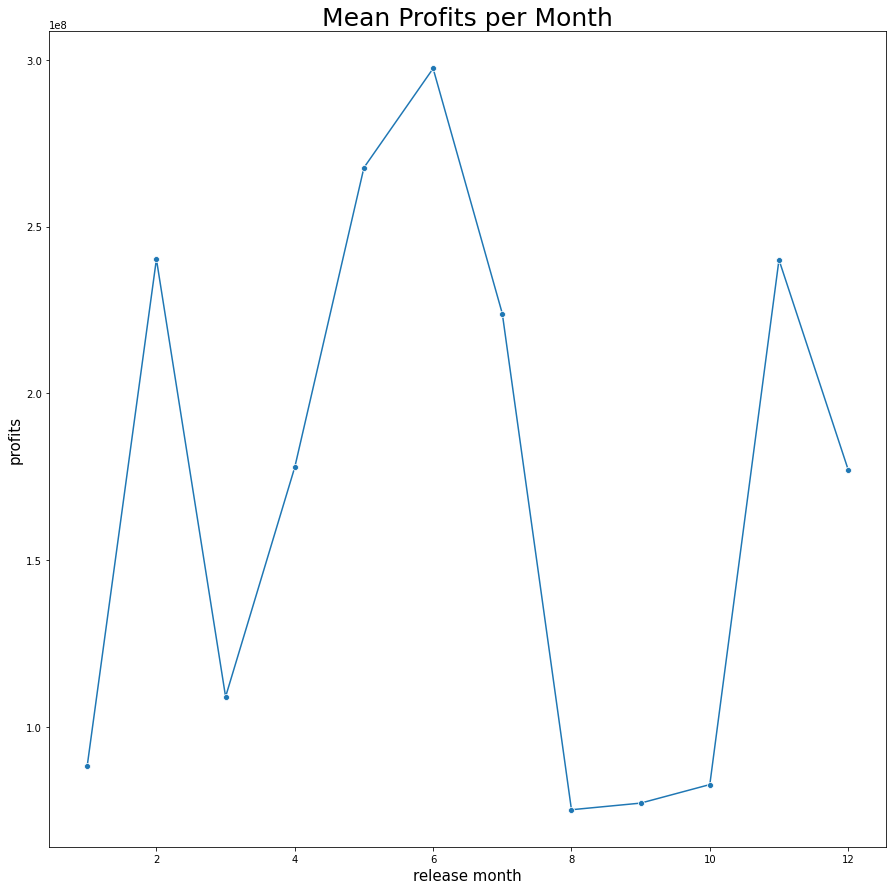

In [302]:
# Monthly Profit Trends (Line Plot)
fig,ax = plt.subplots(figsize=(15,15))
all_combined['release_month'] = pd.to_datetime(all_combined['release_date_x']).dt.month
monthly_profit = all_combined.groupby('release_month')['profits'].mean()
# monthly_profit
months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

sns.lineplot(x=monthly_profit.index, y=monthly_profit.values,marker='o')
# ax.set_xticklabels(months)
plt.title(label='Mean Profits per Month',fontdict={'fontsize':25})
plt.xlabel(fontdict={'fontsize':15},xlabel='release month')
plt.ylabel(fontdict={'fontsize':15},ylabel='profits');


### Question 1: Do movies with top-rated directors (Group A) generate higher profits than those with lower-rated directors (Group B)?

#### Null Hypothesis: Movies with top-rated directors (Group A) generate equal profit compared to those with lower-rated directors (Group B)?

#### Alternative Hypothesis: Movies with top-rated directors (Group A) generate more profits compared to those with lower-rated directors (Group B)?

   #### Groups:

    #####   Group A: Movies directed by directors in the top 10% by averagerating or profits.

    #####    Group B: Movies directed by others.

    #### Metric: Compare mean profits or worldwide_gross.

    #### Method: Use a two-sample t-test to check if the difference is statistically significant.

In [350]:



directors_top_10 = all_combined[all_combined['category'] == 'director'].groupby('primary_name').mean().sort_values('averagerating',ascending=False)
top_100_directors_average_rating_profits = directors_top_10['profits'].head(100)
# mean_profits_top_50_directors = top_50_directors_average_rating_profits.mean()

not_top_100_directors_average_rating_profits = directors_top_10.tail(834)
random_sample_50_not_top_100 = not_top_100_directors_average_rating_profits['profits'].sample(n=50,random_state=6)


alpha = 0.05
t_statistic, p_value = stats.ttest_ind(top_100_directors_average_rating_profits,random_sample_50_not_top_100,equal_var=True)
print('t-stat: ',t_statistic)
print('p_value: ',p_value)

if p_value < alpha:
    print('Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05')
    print('Movies with more popular directors do not generate equal profits')
else:
    print('Failed to reject null hypothesis. Results are not statistically significant')




t-stat:  3.7540972013872054
p_value:  0.0002493613232414284
Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05
Movies with more popular directors do not generate equal profits


In [342]:
all_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'studio', 'domestic_gross_x',
       'foreign_gross', 'year', 'id_x', 'release_date_x', 'movie',
       'production_budget', 'domestic_gross_y', 'worldwide_gross',
       'Unnamed: 0', 'genre_ids', 'id_y', 'original_language',
       'original_title_y', 'popularity', 'release_date_y', 'vote_average',
       'vote_count', 'profits', 'rating_bins', 'release_month'],
      dtype='object')

In [ ]:
# all_combined[ all_combined['category'] == 'actor'].head()

#organize actors by popularity
#null hypothesis: more popular actors dont make same profits
#alternate: more popular actors make more profits.
actors_ranked_popularity = all_combined[all_combined['category'] == 'actor'].groupby('primary_name').mean().sort_values('popularity',ascending=False)
top_200_popular_actors = actors_ranked_popularity['profits'].head(200)
not_top_200_actors = actors_ranked_popularity.tail(1410)
random_sample_200_actors_not_top_200 = not_top_200_actors['profits'].sample(n=200,random_state=42)

alpha = 0.05
t_statistic, p_value = stats.ttest_ind(top_200_popular_actors,random_sample_200_actors_not_top_200,equal_var=True)
print('t-stat: ',t_statistic)
print('p_value: ',p_value)

if p_value < alpha:
    print('Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.')
    print('More popular actors do not make the same profits as less popular actors')
else:
    print('Failed to reject null hypothesis. Results are not statistically significant')


t-stat:  10.40855769547286
p_value:  1.3357002201508975e-22
Null Hypothesis is rejected. Results are statistically significant at alpha = 0.05.
More popular actors do not make the same profits as less popular actors


In [351]:
all_combined.head()

,movie_id,ordering,person_id,category,ordering,title,region,is_original_title,primary_title,original_title_x,...,id_y,original_language,original_title_y,popularity,release_date_y,vote_average,vote_count,profits,rating_bins,release_month
0,tt0475290,10,nm0005683,cinematographer,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328,42160680.0,"(6, 7]",2
1,tt0475290,1,nm0000982,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328,42160680.0,"(6, 7]",2
2,tt0475290,2,nm0000123,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328,42160680.0,"(6, 7]",2
3,tt0475290,3,nm2403277,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328,42160680.0,"(6, 7]",2
4,tt0475290,4,nm0000146,actor,24,"Hail, Caesar!",GB,0.0,"Hail, Caesar!","Hail, Caesar!",...,270487,en,"Hail, Caesar!",12.312,2016-02-05,5.9,2328,42160680.0,"(6, 7]",2


In [352]:
all_combined.columns

Index(['movie_id', 'ordering', 'person_id', 'category', 'ordering', 'title',
       'region', 'is_original_title', 'primary_title', 'original_title_x',
       'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes',
       'primary_name', 'primary_profession', 'studio', 'domestic_gross_x',
       'foreign_gross', 'year', 'id_x', 'release_date_x', 'movie',
       'production_budget', 'domestic_gross_y', 'worldwide_gross',
       'Unnamed: 0', 'genre_ids', 'id_y', 'original_language',
       'original_title_y', 'popularity', 'release_date_y', 'vote_average',
       'vote_count', 'profits', 'rating_bins', 'release_month'],
      dtype='object')

In [358]:
# all_combined[['title','runtime_minutes']].groupby('title').mean().sort_values('runtime_minutes',ascending=True).head(50)

#Question 3: Movies with higher ratings make more profit?

#Null: Movies with higher ratings don't make higher profits?
#alternate: Movies with higher ratings make more profits?


highest_rated_movies = all_combined.groupby('title').mean().sort_values('profits',ascending=False)
highest_rated_movies

,ordering,ordering,is_original_title,start_year,runtime_minutes,averagerating,numvotes,domestic_gross_x,year,id_x,production_budget,worldwide_gross,Unnamed: 0,id_y,popularity,vote_average,vote_count,profits,release_month
title,,,,,,,,,,,,,,,,,,,
Avengers: Infinity War,5.500000,14.000000,0.0,2018.000000,149.000000,8.500000,670926.000000,678800000.0,2018.0,7.0,300000000.0,2.048134e+09,23811.0,299536.0,80.773,8.30,13948.0,1.748134e+09,4.0
Jurassic World,5.500000,29.000000,0.0,2015.000000,124.000000,7.000000,539338.000000,652300000.0,2015.0,34.0,215000000.0,1.648855e+09,14193.0,135397.0,20.709,6.60,14056.0,1.433855e+09,6.0
Furious 7,5.500000,5.500000,0.0,2015.000000,137.000000,7.200000,335074.000000,353000000.0,2015.0,67.0,190000000.0,1.518723e+09,14196.0,168259.0,20.396,7.30,6538.0,1.328723e+09,4.0
Black Panther,5.462185,12.235294,0.0,2017.697479,129.840336,7.216807,477116.966387,700100000.0,2018.0,42.0,200000000.0,1.348258e+09,13630.5,185447.5,23.099,6.25,6188.0,1.148258e+09,2.0
Jurassic World: Fallen Kingdom,5.500000,12.500000,0.0,2018.000000,128.000000,6.200000,219125.000000,417700000.0,2018.0,13.0,170000000.0,1.305773e+09,23829.0,351286.0,34.958,6.50,5995.0,1.135773e+09,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Blackhat,5.500000,11.200000,0.0,2015.000000,133.000000,5.400000,48427.000000,8000000.0,2015.0,47.0,70000000.0,1.966500e+07,14220.0,201088.0,16.824,5.30,1165.0,-5.033500e+07,1.0
R.I.P.D.,5.500000,16.333333,0.0,2013.000000,96.000000,5.600000,109078.000000,33600000.0,2013.0,55.0,130000000.0,7.907668e+07,7889.0,49524.0,21.377,5.60,2047.0,-5.092332e+07,7.0
Monster Trucks,5.500000,10.333333,0.0,2016.000000,104.000000,5.700000,13525.000000,33400000.0,2017.0,81.0,125000000.0,6.164280e+07,20948.0,262841.0,8.827,5.90,414.0,-6.335720e+07,1.0
